In [1]:
import random
import re

from default import PROJECT_HOME
%cd {PROJECT_HOME}

/Users/aflamant/Documents/courses/2024-2025/mémoire/03-code/memoire


In [2]:
from dataset.structural.analysis import LinearAnalysis
from dataset.structural.structure import DummyTruss
from dataset.generator import DummyTrussGenerator
from dataset import DummyTrussDataset
from torch.utils.data import DataLoader
from display import *
from scipy.stats.qmc import Sobol
import matplotlib.pyplot as plt
from typing import Dict, Iterable
import numpy as np

# Example structure

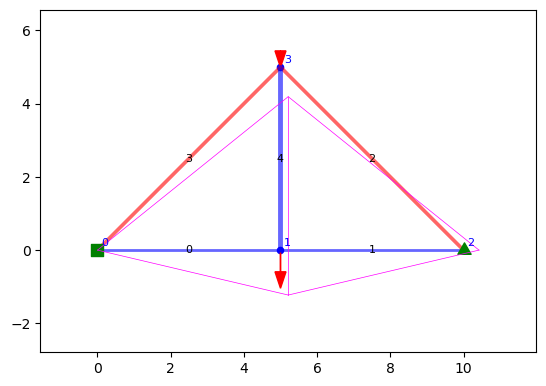

In [3]:
params = {
    'load': -1000e3,
    'volumetric_weight': 78.5e3
}

a = .01
e = 120e9


for i in range(5):
    params[f"A_{i}"] = a
    params[f"E_{i}"] = e

struct = DummyTruss()
struct.generate_model(params)
LinearAnalysis().run_analysis()
g = DummyTrussGenerator()
results = g.construct_result(params)
display_structure(def_scale=100)

In [4]:
def plot(g, def_scale=5):
    fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

    # Flatten the axes array for easier iteration
    axs = axs.flatten()

    for i, r in enumerate(g):
        if i >= 6:  # Since we have 2x3=6 subplots
            break

        display_structure(ax=axs[i], def_scale=def_scale)

    # After plotting all structures, adjust all axes to have same limits
    x_min, x_max = float('inf'), float('-inf')
    y_min, y_max = float('inf'), float('-inf')

    # Find global min and max across all subplots
    for ax in axs:
        x_limits = ax.get_xlim()
        y_limits = ax.get_ylim()
        x_min = min(x_min, x_limits[0])
        x_max = max(x_max, x_limits[1])
        y_min = min(y_min, y_limits[0])
        y_max = max(y_max, y_limits[1])

    # Make the scale the same in both directions - take the wider range
    total_range = max(x_max - x_min, y_max - y_min)
    x_center = (x_max + x_min) / 2
    y_center = (y_max + y_min) / 2

    # Apply the same limits to all subplots
    for ax in axs:
        ax.set_xlim(x_center - total_range / 2, x_center + total_range / 2)
        ax.set_ylim(y_center - total_range / 2, y_center + total_range / 2)

        # Ensure aspect ratio is equal
        ax.set_aspect('equal')

    plt.tight_layout()

In [5]:
def sobol_sample(ranges: Dict | Iterable, size, seed=None):
    sampler = Sobol(d=len(ranges), scramble=True, seed=seed)
    sampling = sampler.random(n=size)

    if isinstance(ranges, dict):
        scaled_sampling = dict()
        for i, k in enumerate(ranges.keys()):
            min_val, max_val = ranges[k]
            scaled_sampling[k] = sampling[:, i] * (max_val - min_val) + min_val
    else:
        scaled_sampling = sampling.copy()
        for i, (min_val, max_val) in enumerate(ranges):
            scaled_sampling[:, i] = sampling[:, i] * (max_val - min_val) + min_val

    return scaled_sampling

# Train set
We will generate sets of multiple size

Dataset saved to data/dataset/dummy_truss/128.hdf5
Dataset saved to data/dataset/dummy_truss/256.hdf5
Dataset saved to data/dataset/dummy_truss/512.hdf5
Dataset saved to data/dataset/dummy_truss/1024.hdf5
Dataset saved to data/dataset/dummy_truss/2048.hdf5
Dataset saved to data/dataset/dummy_truss/4096.hdf5
Dataset saved to data/dataset/dummy_truss/val_512.hdf5


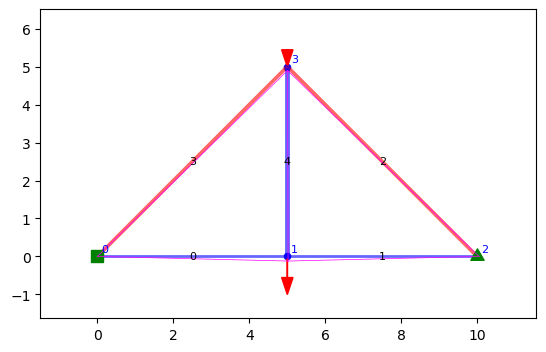

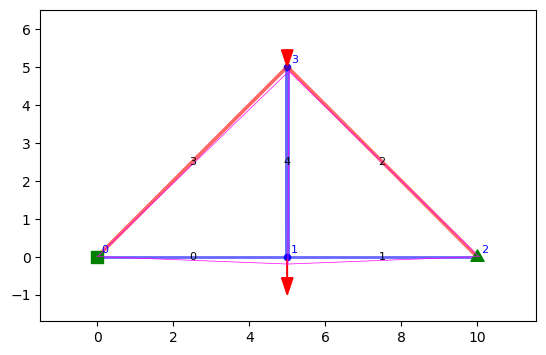

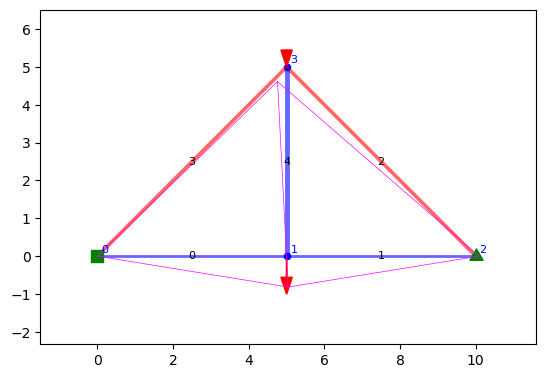

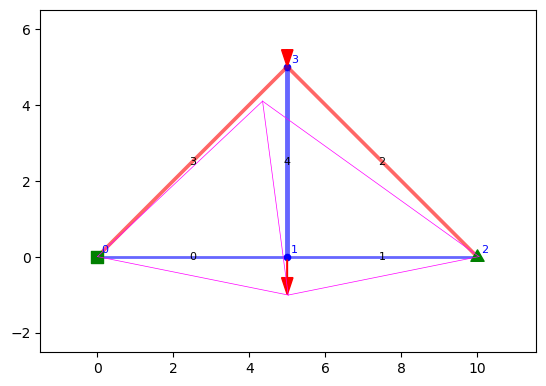

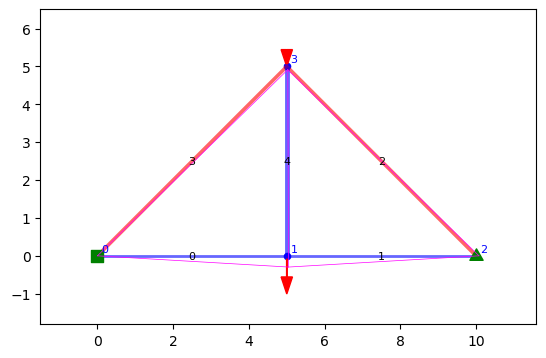

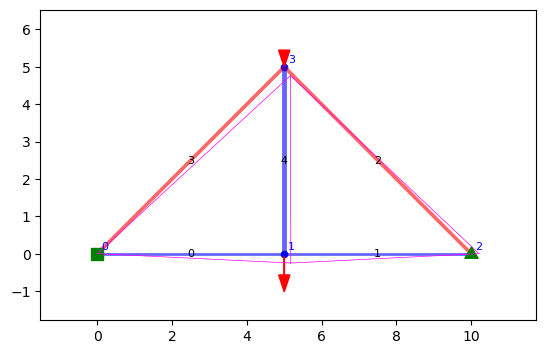

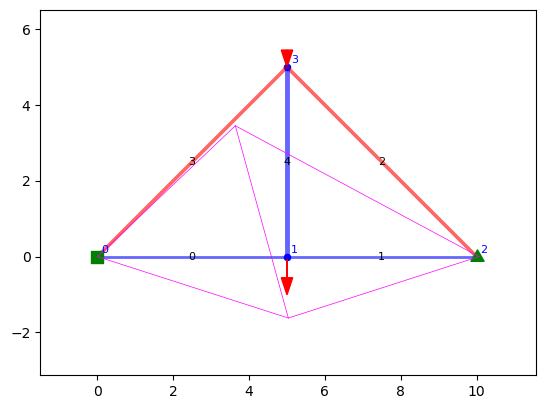

In [6]:
def generate_dataset(size, filepath, display=True,
                     young_range=(150e9, 250e9), area_range=(1e-3, 5e-2), load_range=(-10_000.e3, 0.0)):
    def routine(size, params_ranges, default_params=None):
        if default_params is None:
            default_params = {
                'volumetric_weight': 78.5e3
            }

        samples = sobol_sample(
            ranges=params_ranges,
            size=size,
        )

        results_iterator = []
        for i in range(size):
            params = default_params.copy()
            params.update({f"A_{j}": samples[f'a_{j}'][i] for j in range(5)})
            params.update({f"E_{j}": samples[f'e_{j}'][i] for j in range(5)})

            params[f"load"] = samples[f"load"][i]

            struct = DummyTruss()
            struct.generate_model(params)
            LinearAnalysis().run_analysis()
            g = DummyTrussGenerator(structure=struct)

            results_iterator.append(g.construct_result(params))

        return results_iterator

    # Random loads
    params_ranges = {f'e_{i}': young_range for i in range(5)}
    params_ranges.update({f'a_{i}': area_range for i in range(5)})
    params_ranges.update({f'load': load_range})

    results_iterator = routine(size, params_ranges)

    random.shuffle(results_iterator)  # mixing up all modes
    if filepath is not None: g.save_from_iterator(results_iterator, filepath, max_size=len(results_iterator))
    if display: display_structure(def_scale=10)

    return results_iterator


dir_path = f"data/dataset/dummy_truss"
for size in [2**i for i in range(7,13)]:
    generate_dataset(size, f'{dir_path}/{size}.hdf5')

results = generate_dataset(512, f'{dir_path}/val_512.hdf5')

In [7]:
ds = DummyTrussDataset("data/dataset/dummy_truss/128.hdf5")
dl = DataLoader(ds, batch_size=25)
x, y, u, q, w, r = dl.__iter__().__next__()

In [9]:
y


tensor([[6.8111e+09, 7.6380e+08, 3.7591e+09, 4.8766e+08, 5.8949e+09],
        [7.9193e+08, 8.7436e+09, 5.0415e+09, 5.5346e+09, 8.5763e+09],
        [9.1095e+09, 5.3886e+09, 8.9194e+09, 3.2114e+09, 7.9131e+09],
        [6.0200e+09, 3.0732e+09, 2.7385e+09, 4.6448e+09, 5.1670e+09],
        [8.4993e+09, 2.8899e+09, 7.0636e+09, 4.5689e+09, 8.4392e+09],
        [9.1220e+09, 8.6420e+09, 1.9187e+09, 3.5097e+09, 9.1790e+09],
        [5.8422e+09, 1.0172e+10, 1.3301e+09, 3.8027e+09, 4.5607e+09],
        [1.6947e+09, 2.0155e+09, 1.9849e+09, 9.3462e+09, 3.7814e+09],
        [5.2242e+09, 6.1013e+09, 2.3897e+08, 1.4177e+09, 4.5411e+09],
        [7.5016e+09, 8.1924e+09, 6.8612e+09, 7.6245e+09, 2.8797e+09],
        [4.0498e+09, 3.4059e+09, 6.3684e+09, 1.6088e+09, 2.1774e+09],
        [4.8983e+09, 5.8204e+09, 4.6151e+09, 2.1968e+09, 5.8615e+09],
        [2.3915e+09, 7.1350e+09, 2.1989e+09, 5.2896e+09, 3.5245e+09],
        [9.3548e+09, 5.5602e+09, 5.2266e+09, 1.0533e+10, 1.6935e+09],
        [1.0396e+10,